# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://open.spotify.com/track/4R3AU2pjv8ge2siX1fVbZs?si=b2712f32da0e4358) or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [1]:
# Load the libraries as required.
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from scipy.stats import skew
import pickle


In [2]:
# Load data
fire_dt = pd.read_csv(r'C:\Users\arezo\DSI_Assignments\production\production\05_src\data\fires\forestfires.csv')

fire_dt.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


# Get X and Y

Create the features data frame and target data.

In [3]:
# Create Feature and Target Data
X = fire_dt.drop('area', axis = 1)
Y = fire_dt['area']

In [4]:
# Describe Statistical Aspects of Data
X.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000


Data distribution suggests outlier existence in the data. Therefore, robust scaler seems a better choice for scaling

In [5]:
# Split the Dataset to the Training and Test Set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [6]:
# Define Numerical and Categorical Features
numeric_features = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
categorical_features = ['month', 'day']

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

### Preproc 2

Create preproc2 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [7]:
# Preprocessing Pipelines
# Preproc1: Scaling only for numeric, OneHotEncoding for categorical

# Numerical Feature Transformer
numeric_transformer = Pipeline([('scaler', RobustScaler())])

# Categorical Feature Transformer
categorical_transformer = Pipeline([('ohe', OneHotEncoder(drop = 'first', handle_unknown = 'infrequent_if_exist'))])

# Preprocessing Pipeline
preproc1 = ColumnTransformer(
    transformers = [
        ('num_transforms', numeric_transformer, numeric_features), 
        ('cat_transforms', categorical_transformer, categorical_features)
    ]
)

preproc1

ColumnTransformer(transformers=[('num_transforms',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp',
                                  'RH', 'wind', 'rain']),
                                ('cat_transforms',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist'))]),
                                 ['month', 'day'])])

In [8]:
# Check skewness for numerical features
skewness_values = X_train[numeric_features].apply(skew)
print("Skewness values:\n", skewness_values)

# Define a New Numerical Feature Set with High Skew to Apply Power Transformer
other_numeric_features = [col for col in numeric_features if abs(skewness_values[col]) > 1]
other_numeric_features

Skewness values:
 X        0.021570
Y        0.409679
FFMC    -6.649868
DMC      0.621077
DC      -1.039188
ISI      0.580039
temp    -0.267185
RH       0.865969
wind     0.549763
rain    17.817623
dtype: float64


['FFMC', 'DC', 'rain']

In [9]:
# Preprocessing Pipelines
# Preproc2: Scaling with non-linear transformations for numeric, OneHotEncoding for categorical

# Numerical Feature Transformer
numeric_transformer = Pipeline([('scaler', StandardScaler())])

# Other Numerical Feature Transformer
other_numeric_transformer = Pipeline([('transform', PowerTransformer(method='yeo-johnson'))])

# Categorical Feature Transformer
categorical_transformer = Pipeline([('ohe', OneHotEncoder(drop = 'first', handle_unknown = 'infrequent_if_exist'))])

# Preprocessing Pipeline
preproc2 = ColumnTransformer(
    transformers = [
        ('num_transforms', numeric_transformer, numeric_features),  
        ('other_num_transforms', other_numeric_transformer, other_numeric_features),  
        ('cat_transforms', categorical_transformer, categorical_features)
    ]
)

preproc2

ColumnTransformer(transformers=[('num_transforms',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp',
                                  'RH', 'wind', 'rain']),
                                ('other_num_transforms',
                                 Pipeline(steps=[('transform',
                                                  PowerTransformer())]),
                                 ['FFMC', 'DC', 'rain']),
                                ('cat_transforms',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist'))]),
                                 ['month', 'day'])])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [10]:
# Define model evaluation function
def cross_validation(pipeline, X_train, Y_train):
    
    scoring = ['neg_root_mean_squared_error', 'max_error']
    cv_results = cross_validate(pipeline, X_train, Y_train, cv=5, scoring=scoring, return_train_score=True)
    return pd.DataFrame(cv_results).mean()

In [11]:
# Pipeline A = preproc1 + baseline

# Create Model Pipeline
Pipeline_A = Pipeline(steps = [
    ('preprocessing', preproc1),
    ('Regressor', LinearRegression())
])

# Fit the Regressor
Pipeline_A.fit(X_train, Y_train)

# Apply Cross Validation
cv_mean_results_A = cross_validation(Pipeline_A, X_train, Y_train)

c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [12]:
# Pipeline B = preproc2 + baseline

# Create Model Pipeline
Pipeline_B = Pipeline(steps = [
    ('preprocessing', preproc2),
    ('Regressor', LinearRegression())
])

# Fit the Regressor
Pipeline_B.fit(X_train, Y_train)

# Apply Cross Validation
cv_mean_results_B = cross_validation(Pipeline_B, X_train, Y_train)

c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [13]:
# Pipeline C = preproc1 + advanced model (Decision Tree Regressor)

# Create Model Pipeline
Pipeline_C = Pipeline(steps = [
    ('preprocessing', preproc1),
    ('Regressor', DecisionTreeRegressor(random_state=42))
])

# Fit the Regressor
Pipeline_C.fit(X_train, Y_train)

# Apply Cross Validation
cv_mean_results_C = cross_validation(Pipeline_C, X_train, Y_train)

c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [14]:
# Pipeline D = preproc2 + advanced model (Decision Tree Regressor)

# Create Model Pipeline
Pipeline_D = Pipeline(steps = [
    ('preprocessing', preproc2),
    ('Regressor', DecisionTreeRegressor(random_state=42))
])

# Fit the Regressor
Pipeline_D.fit(X_train, Y_train)

# Apply Cross Validation
cv_mean_results_D = cross_validation(Pipeline_D, X_train, Y_train)

c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


The large difference between training and test metrics can be a sign of overfitting 

In [15]:
# Pipeline E = preproc1 + advanced model (Random Forest Regressor)

# Create Model Pipeline
Pipeline_E = Pipeline(steps = [
    ('preprocessing', preproc1),
    ('Regressor', RandomForestRegressor(random_state=42))
])

# Fit the Regressor
Pipeline_E.fit(X_train, Y_train)

# Apply Cross Validation
cv_mean_results_E = cross_validation(Pipeline_E, X_train, Y_train)

c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Random Forest shows the best performance.

In [16]:
# Pipeline F = preproc2 + advanced model (Random Forest Regressor)

# Create Model Pipeline
Pipeline_F = Pipeline(steps = [
    ('preprocessing', preproc2),
    ('Regressor', RandomForestRegressor(random_state=42))
])

# Fit the Regressor
Pipeline_F.fit(X_train, Y_train)

# Apply Cross Validation
cv_mean_results_F = cross_validation(Pipeline_F, X_train, Y_train)

c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [17]:
# Define model optimizer function

def optimizer(pipeline, X_train, Y_train, param_grid):
    # Apply GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, Y_train)

    # Apply Cross Validation on the best estimator
    cv_results = cross_validation(grid_search.best_estimator_, X_train, Y_train)

    # Return both Best parameters and cv_results with dynamic naming
    return {
        "Best_parameters": grid_search.best_params_,
        f"cv_results_{pipeline.steps[-1][1].__class__.__name__}": cv_results
    }

# Define param_grid for each model
param_grid_for_DecisionTreeRegressor= {
    'Regressor__max_depth': [1,2,3,4,5,6,7,8,9,10,None],
    'Regressor__min_samples_leaf': [1,2,4]
}

param_grid_for_RandomForestRegressor = {
    'Regressor__n_estimators': [10, 50, 100, 200],
    'Regressor__max_depth': [None, 5, 10],
    'Regressor__min_samples_leaf': [1,2,4]
}

In [18]:
# Pipeline C = preproc1 + advanced model (Decision Tree Regressor)

# Apply optimizer function
results = optimizer(Pipeline_C, X_train, Y_train, param_grid_for_DecisionTreeRegressor)
cv_mean_results_C_tuned = results[f"cv_results_{Pipeline_C.steps[-1][1].__class__.__name__}"]

# Print results
print(f'Best Parameters for {Pipeline_C.steps[-1][1].__class__.__name__}:')
print(results["Best_parameters"])

print("\nCross-Validation Results:")
print(cv_mean_results_C_tuned)

c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\are

Best Parameters for DecisionTreeRegressor:
{'Regressor__max_depth': 1, 'Regressor__min_samples_leaf': 4}

Cross-Validation Results:
fit_time                               0.005371
score_time                             0.002712
test_neg_root_mean_squared_error     -42.319130
train_neg_root_mean_squared_error    -46.697842
test_max_error                      -289.151368
train_max_error                     -611.836297
dtype: float64


c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [19]:
# Pipeline D = preproc2 + advanced model (Decision Tree Regressor)

# Apply optimizer function
results = optimizer(Pipeline_D, X_train, Y_train, param_grid_for_DecisionTreeRegressor)
cv_mean_results_D_tuned = results[f"cv_results_{Pipeline_D.steps[-1][1].__class__.__name__}"]

# Print results
print(f'Best Parameters for {Pipeline_D.steps[-1][1].__class__.__name__}:')
print(results["Best_parameters"])

print("\nCross-Validation Results:")
print(cv_mean_results_D_tuned)

c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\are

Best Parameters for DecisionTreeRegressor:
{'Regressor__max_depth': 1, 'Regressor__min_samples_leaf': 4}

Cross-Validation Results:
fit_time                               0.007413
score_time                             0.003202
test_neg_root_mean_squared_error     -42.319130
train_neg_root_mean_squared_error    -46.697842
test_max_error                      -289.151368
train_max_error                     -611.836297
dtype: float64


In [20]:
# Pipeline E = preproc1 + advanced model (Random Forest Regressor)

# Apply optimizer function
results = optimizer(Pipeline_E, X_train, Y_train, param_grid_for_RandomForestRegressor)
cv_mean_results_E_tuned = results[f"cv_results_{Pipeline_E.steps[-1][1].__class__.__name__}"]

# Print results
print(f'Best Parameters for {Pipeline_E.steps[-1][1].__class__.__name__}:')
print(results["Best_parameters"])

print("\nCross-Validation Results:")
print(cv_mean_results_E_tuned)

c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\are

Best Parameters for RandomForestRegressor:
{'Regressor__max_depth': 5, 'Regressor__min_samples_leaf': 4, 'Regressor__n_estimators': 200}

Cross-Validation Results:
fit_time                               0.207473
score_time                             0.007938
test_neg_root_mean_squared_error     -44.179587
train_neg_root_mean_squared_error    -39.406261
test_max_error                      -292.876722
train_max_error                     -517.058188
dtype: float64


c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [21]:
# Pipeline F = preproc2 + advanced model (Random Forest Regressor)

# Apply optimizer function
results = optimizer(Pipeline_F, X_train, Y_train, param_grid_for_RandomForestRegressor)
cv_mean_results_F_tuned = results[f"cv_results_{Pipeline_F.steps[-1][1].__class__.__name__}"]

# Print results
print(f'Best Parameters for {Pipeline_F.steps[-1][1].__class__.__name__}:')
print(results["Best_parameters"])

print("\nCross-Validation Results:")
print(cv_mean_results_F_tuned)

c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\are

Best Parameters for RandomForestRegressor:
{'Regressor__max_depth': 5, 'Regressor__min_samples_leaf': 4, 'Regressor__n_estimators': 200}

Cross-Validation Results:
fit_time                               0.241020
score_time                             0.010014
test_neg_root_mean_squared_error     -44.186802
train_neg_root_mean_squared_error    -39.409181
test_max_error                      -292.472904
train_max_error                     -517.045478
dtype: float64


c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# Evaluate

+ Which model has the best performance?

In [22]:
results_summary = {
    'Linear Regression and Preproc1': cv_mean_results_A,  
    'Linear Regression and Preproc2': cv_mean_results_B,
    'Decision Tree Regression and Preproc1': cv_mean_results_C_tuned,
    'Decision Tree Regression and Preproc2': cv_mean_results_D_tuned,
    'Random Forest Regression and Preproc1': cv_mean_results_E_tuned,
    'Random Forest Regression and Preproc2': cv_mean_results_F_tuned,
}

In [23]:
results_df = pd.DataFrame(results_summary)
sorted_results_df = results_df.T.sort_values(by='test_neg_root_mean_squared_error', ascending=False)
sorted_results_df

,fit_time,score_time,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,test_max_error,train_max_error
Decision Tree Regression and Preproc1,0.005371,0.002712,-42.319130,-46.697842,-289.151368,-611.836297
Decision Tree Regression and Preproc2,0.007413,0.003202,-42.319130,-46.697842,-289.151368,-611.836297
Linear Regression and Preproc1,0.006700,0.003896,-43.980136,-46.011513,-298.113067,-603.154407
Random Forest Regression and Preproc1,0.207473,0.007938,-44.179587,-39.406261,-292.876722,-517.058188
Random Forest Regression and Preproc2,0.241020,0.010014,-44.186802,-39.409181,-292.472904,-517.045478
Linear Regression and Preproc2,0.010401,0.004599,-44.665964,-45.874010,-307.972224,-602.786738


In [24]:
Best_model = sorted_results_df[sorted_results_df['test_neg_root_mean_squared_error']==sorted_results_df['test_neg_root_mean_squared_error'].max()]
print('Our best model with the lowest test_neg_root_mean_squared_error is:', Best_model.index[0])

Our best model with the lowest test_neg_root_mean_squared_error is: Decision Tree Regression and Preproc1


In [25]:
# Dictionary mapping pipeline names to their objects
pipeline_dict = {
    'Linear Regression and Preproc1': Pipeline_A,
    'Linear Regression and Preproc2': Pipeline_B,
    'Decision Tree Regression and Preproc1': Pipeline_C,
    'Decision Tree Regression and Preproc2': Pipeline_D,
    'Random Forest Regression and Preproc1': Pipeline_E,
    'Random Forest Regression and Preproc2': Pipeline_F
}

In [26]:
# Get the name of the best pipeline
best_pipeline_name = sorted_results_df.index[0]

# Retrieve and save the best pipeline
best_pipeline = pipeline_dict[best_pipeline_name]

# Export

+ Save the best performing model to a pickle file.

In [27]:
# Save the best model to a pickle file
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_pipeline, file)

print(f"The best model ({best_pipeline_name}) has been saved to 'best_model.pkl'.")

The best model (Decision Tree Regression and Preproc1) has been saved to 'best_model.pkl'.


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [28]:
with open('best_model.pkl', 'rb') as file:
    best_model = pickle.load(file)
best_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transforms',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['X', 'Y', 'FFMC', 'DMC',
                                                   'DC', 'ISI', 'temp', 'RH',
                                                   'wind', 'rain']),
                                                 ('cat_transforms',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='infrequent_if_exist'))]),
                                                  ['month', 'day'])])),
                ('Regressor', DecisionTreeRegressor(random_state=42))])

In [29]:
import shap

# Apply preproc1 to transform X_test
data_transform = best_model.named_steps['preprocessing'].transform(X_test)

# Ensure feature names are correct after transformation
feature_names = best_model.named_steps['preprocessing'].get_feature_names_out()

# Check the steps in the best pipeline
print(best_model.named_steps)

# Initialize the explainer for the decision tree model
explainer = shap.Explainer(best_model.named_steps['Regressor'], data_transform, feature_names = feature_names)

# Compute SHAP values
shap_values = explainer(data_transform, check_additivity=False)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


{'preprocessing': ColumnTransformer(transformers=[('num_transforms',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp',
                                  'RH', 'wind', 'rain']),
                                ('cat_transforms',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist'))]),
                                 ['month', 'day'])]), 'Regressor': DecisionTreeRegressor(random_state=42)}


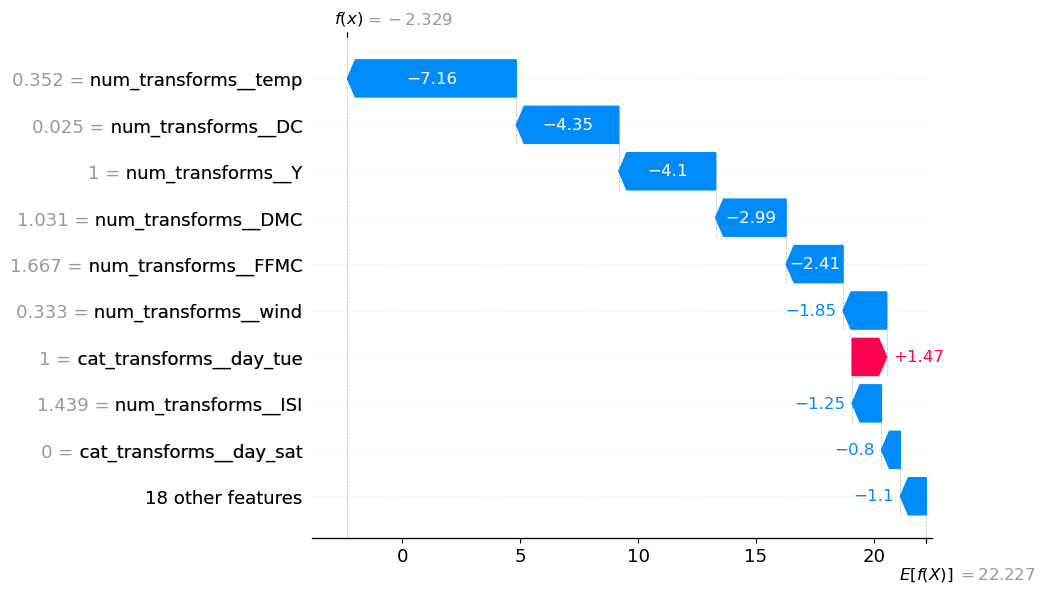

In [30]:
shap.plots.waterfall(shap_values[1])

For this specific observation, temperature seems to be the most important feature in predicting the burned area. Higher temperature results in larger burned area.

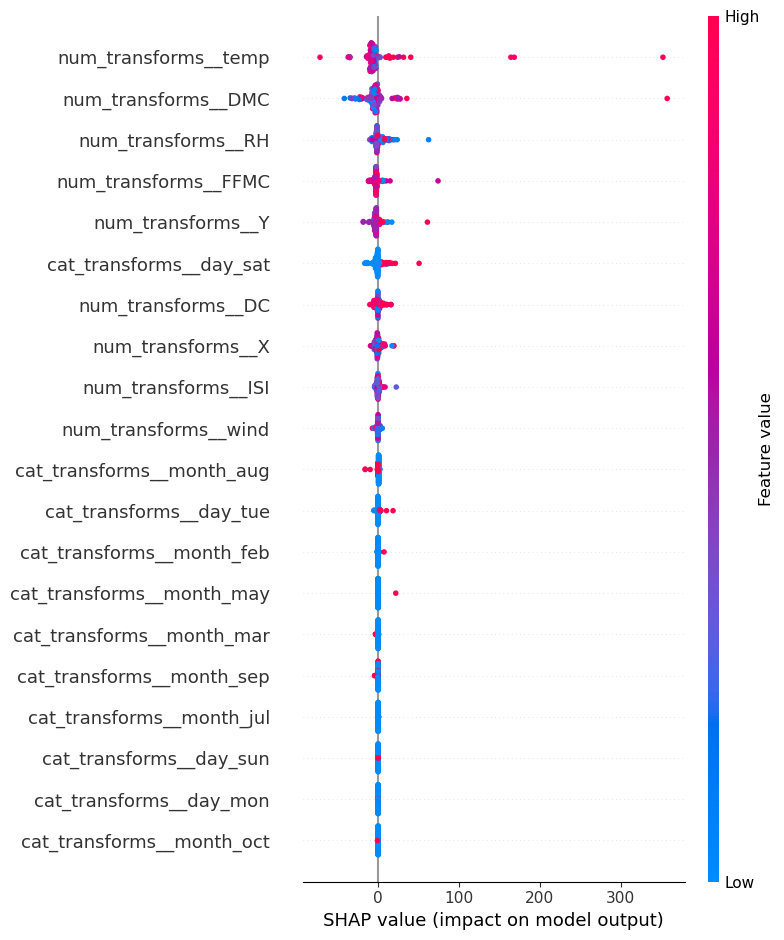

In [31]:
# Compute SHAP values for the entire test set
shap_values_all = explainer(data_transform, check_additivity=False)

# Summary plot to show overall feature importance
shap.summary_plot(shap_values_all, feature_names=feature_names)

In summary, temperature seems to be the most important feature in predicting the burned area. Higher temperature results in larger burned area.
Months of Oct and Jul and days Sunday and Monday seems to be the least important features.
In general, temperature is the most important feature and month and day are the least important ones. 

Testing Feature Impact on Model Performance

I would remove the least important features, create a new dataset and train the model using this reduced set of features.
Then, I evaluate the new model's performance on the same validation set used for the baseline model and implement cross-validation to ensure the results are robust.

## Criteria

The [rubric](./assignment_3_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.